Pretrained Neural Networks like VGG16/VGG19/ResNet/DenseNet are trained on ImageNet which contains 1000-class images. This competition just contains two classes: cat and dog. In this kernel, I want to demonstrate how to build a model with **Pytorch** to classify dog or cat to **Finetuning the convnet**, and then **fix ConvNet to extract image features**. 

This include four steps:

- Build Dog/Cat classify dataset for supervised training.
- Prepare dataset for Pytorch.
- Fintune pretrained ResNet-18 model.
- Fixed ConvNet to extract image features.

Reference:

- [Extract Image features from pretrained NN](https://www.kaggle.com/christofhenkel/extract-image-features-from-pretrained-nn)
- [Transfer Learning Using Pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

**Please UPVOTE if you find it useful** :)

In [2]:
import os
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
plt.ion()   # interactive mode

import time
from tqdm import tqdm, trange
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from shutil import copyfile
print(os.listdir(r"./input"))

['adoption_folders', 'images256', 'keras-applications-weights', 'keras-applications-weights.zip', 'petfinder-adoption-prediction']


In [3]:
train_df = pd.read_csv(r'./input/petfinder-adoption-prediction/train/train.csv')
test_df = pd.read_csv(r'./input/petfinder-adoption-prediction/test/test.csv')
test_df['AdoptionSpeed'] = [-1] * len(test_df)
data_df = pd.concat([train_df, test_df], axis=0).reset_index()
print(train_df.shape[0], test_df.shape[0], data_df.shape[0])

14993 3948 18941


In [4]:
data_df.head(2)

,index,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,0,2,Nibble,3,299,0,1,1,7,0,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,1,2,No Name Yet,1,265,0,1,1,2,0,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0


## Split Dog/Cat images for supervised training

In [5]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

class DogCatDataset(Dataset):
    """Dog Cat classify dataset."""
    
    def __init__(self, data_df, root_dir=r'C:\Users\vinograd\Documents\PetFinder\input\petfinder-adoption-prediction', train_or_valid='train', transform=None):
        super(DogCatDataset, self).__init__()
        self.classes = ['dog', 'cat']
        self.class_to_idx = {'dog':0, 'cat':1}
        
        self.transform = transform
        self.img_list = [] # read train/valid image path
        petids = data_df['PetID'].values
        for petid in tqdm(petids):
            row = data_df.loc[data_df['PetID'] == petid, :]
            anim_type = 'cat' if row['Type'].values[0] == 2 else 'dog'
            photo_amt = row['PhotoAmt'].values[0]
            img_type = 'train' if row['AdoptionSpeed'].values[0] >= 0 else 'test'
            
            if train_or_valid == 'train':
                for i in range(2, int(photo_amt) + 1):
                    img_path = f'{root_dir}{img_type}_images\\{petid}-{i}.jpg'
                    if not os.path.exists(img_path): continue
                    self.img_list.append((img_path, self.class_to_idx[anim_type]))
            else:  # valid
                img_path = f'{root_dir}{img_type}_images\\{petid}-1.jpg'
                if not os.path.exists(img_path): continue
                self.img_list.append((img_path, self.class_to_idx[anim_type]))
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        path, target = self.img_list[index]
        image = default_loader(path)
        if self.transform is not None:
            image = self.transform(image)
        return image, target
        

In [6]:
set(data_df['AdoptionSpeed'].values)

{-1, 0, 1, 2, 3, 4}

In [46]:
os.mkdir('./input/adoption_folders/train/')
os.mkdir('./input/adoption_folders/valid/')
for i in set(data_df['AdoptionSpeed'].values):
    print(i)
    if i>=0:
        os.mkdir('./input/adoption_folders/train/'+str(i))
        os.mkdir('./input/adoption_folders/valid/'+str(i))

0
1
2
3
4
-1


In [44]:
root_dir=r'./input/petfinder-adoption-prediction/train/train_images/'
save_dir = r'./input/adoption_folders/'
petids = data_df['PetID'].values

In [43]:
import matplotlib.image as mpimg
img =mpimg.imread(r'input/petfinder-adoption-prediction/train/train_images/86e1089a3-1.jpg',-1)
img

array([[[ 31,  35,  36],
        [ 31,  35,  36],
        [ 30,  34,  35],
        ...,
        [133, 145, 145],
        [133, 145, 145],
        [121, 133, 133]],

       [[ 35,  39,  40],
        [ 36,  40,  41],
        [ 36,  40,  41],
        ...,
        [132, 144, 144],
        [131, 143, 143],
        [124, 136, 136]],

       [[ 32,  36,  37],
        [ 34,  38,  39],
        [ 36,  40,  41],
        ...,
        [128, 140, 140],
        [126, 138, 138],
        [125, 137, 137]],

       ...,

       [[127, 140, 146],
        [132, 145, 151],
        [133, 146, 152],
        ...,
        [124, 130, 130],
        [128, 134, 134],
        [129, 135, 135]],

       [[127, 140, 146],
        [131, 144, 150],
        [133, 146, 152],
        ...,
        [125, 131, 131],
        [126, 132, 132],
        [120, 126, 126]],

       [[125, 140, 145],
        [128, 143, 148],
        [129, 144, 149],
        ...,
        [132, 138, 138],
        [129, 135, 135],
        [117, 123, 123]]

In [59]:
root_dir=r'./input/petfinder-adoption-prediction/train/train_images/'
save_dir = r'./input/adoption_folders/'
petids = data_df['PetID'].values
for petid in tqdm(petids):
    row = data_df.loc[data_df['PetID'] == petid, :]
    photo_amt = row['PhotoAmt'].values[0]
    adoption = row['AdoptionSpeed'].values[0]
    if adoption>=0:
        i=1
        img_name = str(petid)+'-'+str(i)+'.jpg'
        #print(root_dir+img_name)
        cv2.imwrite(save_dir+'valid/'+str(adoption)+'/'+img_name,cv2.imread(root_dir+img_name))
        for i in range(2, int(photo_amt) + 1):
            img_name = str(petid)+'-'+str(i)+'.jpg'
            cv2.imwrite(save_dir+'train/'+str(adoption)+'/'+img_name,cv2.imread(root_dir+img_name))

len(petids)

100%|████████████████████████████████████████████████████████████████████████████| 18941/18941 [19:24<00:00, 16.26it/s]


18941

Here we use `PetID-1.jpg`(default profile) image for valid image per PetId, and finally we have 68350 training images and 5000 valid images, the `cat : dog = 1 : 1`

In [7]:
batch_size = 16

image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(r'input\adoption_folders', x),
                                          image_transforms[x])for x in ['train', 'valid']}
print('image_datasets - done')
dataloaders = {x: torch.utils.data.dataloader.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'valid']}

image_datasets - done


In [8]:
print('Train:', len(image_datasets['train']), ', Valid:', len(image_datasets['valid']))
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('class:', class_names)
print('device:', device)

Train: 43659 , Valid: 14652
class: ['0', '1', '2', '3', '4']
device: cuda:0


## Visualize a few images

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 6))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

In [16]:
dataloaders['train'][0]

TypeError: 'DataLoader' object does not support indexing

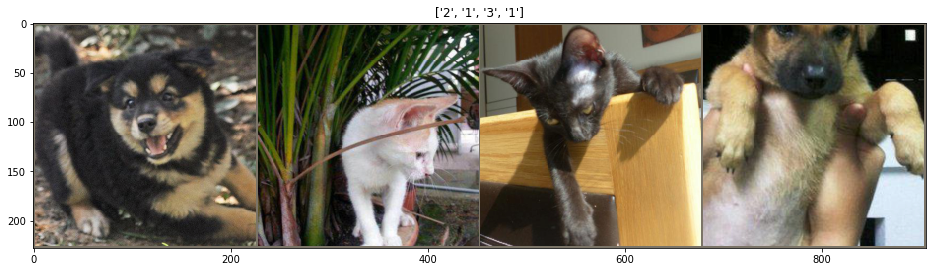

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

# original tutorial

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,dataloaders=dataloaders):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(inputs.shape, outputs.shape)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                cv2.imwrite('out.png',inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)
#model_ft = model_newinput.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)#25)

Epoch 0/3
----------
train Loss: 1.4689 Acc: 0.3150
valid Loss: 1.5064 Acc: 0.3397

Epoch 1/3
----------
train Loss: 1.4105 Acc: 0.3537
valid Loss: 1.4911 Acc: 0.3397

Epoch 2/3
----------


KeyboardInterrupt: 

In [26]:
def kappa_loss(p, y, n_classes=5, eps=1e-10):
    """
    QWK loss function as described in https://arxiv.org/pdf/1612.00775.pdf
    
    Arguments:
        p: a tensor with probability predictions, [batch_size, n_classes],
        y, a tensor with one-hot encoded class labels, [batch_size, n_classes]
    Returns:
        QWK loss
    """
    #print(len(y))
    batch_size = len(y)
#nb_digits = 10
# Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
#y = torch.LongTensor(batch_size,1).random_() % nb_digits
# One hot encoding buffer that you create out of the loop and just keep reusing
    #y_onehot = torch.cuda.FloatTensor(batch_size, n_classes)

# In your for loop
    #y_onehot.zero_()
    #y_onehot.scatter_(1, y, 1)
    ey = torch.eye(n_classes,device='cuda:0') 
    #return ey[labels]
    eye =ey[y]
    #print(y_onehot)
    W = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            W[i,j] = (i-j)**2
    
    W = torch.from_numpy(W.astype(np.float32)).to(device)
    #print(eye,p)
    O = torch.matmul(eye.t(), p)
    E = torch.matmul(eye.sum(dim=0).view(-1,1), p.sum(dim=0).view(1,-1)) / O.sum()
    
    return (W*O).sum() / ((W*E).sum() + eps)

model_kappa = train_model(model_ft, kappa_loss, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)#25)

Epoch 0/2
----------
train Loss: -420.3309 Acc: 0.2993
valid Loss: -1307.6529 Acc: 0.2528

Epoch 1/2
----------
train Loss: -2587.3121 Acc: 0.2057
valid Loss: -5951.7933 Acc: 0.2562

Epoch 2/2
----------
train Loss: -14038.8366 Acc: 0.2195
valid Loss: -36004.1788 Acc: 0.2719

Training complete in 37m 53s
Best val Acc: 0.271908


In [34]:
model_ft.conv1.in_channels

3

In [28]:
new_model_2_removed = nn.Sequential(*list(model_ft.children())[1:])
child_counter = 0
for child in new_model_2_removed.children():
    print(" child", child_counter, "is -")
    print(child)
    child_counter += 1

 child 0 is -
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 1 is -
ReLU(inplace)
 child 2 is -
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 3 is -
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1

## Finetuning the pretrained model

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs, classes = inputs[:4], classes[:4]
ground_truth = [class_names[i] for i in classes]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

inputs = inputs.cuda()
preds = model_ft(inputs)
_, preds = torch.max(preds, 1)
predict_class = [class_names[i] for i in preds]
imshow(out, title=f"Truth : {ground_truth}\nPredict: {predict_class}")

In [57]:
image_features = []
def hook_feature(module, input, output):
    # hook the feature extractor
    image_features.append(np.squeeze(output.data.cpu().numpy()))

model._modules.get('avgpool').register_forward_hook(hook_feature)

## Extract Train Image Features

In [ ]:
extract_transform = image_transforms['valid']

In [ ]:
train_pids = train_df.PetID.values
input_tensor = torch.zeros(1, 3, 224, 224)

train_image_features = {}
for petid in tqdm(train_pids):
    train_img = f"../input/train_images/{petid}-1.jpg"
    if not os.path.exists(train_img): continue
    
    train_img = Image.open(train_img)
    train_img = extract_transform(train_img)
    input_tensor[0, :, :, :] = train_img
    input_tensor = input_tensor.cuda()
    model(input_tensor)
    train_image_features[petid] = image_features[0]
    image_features.clear()


In [ ]:
train_image_features = pd.DataFrame.from_dict(train_image_features, orient='index')
train_image_features.columns = [f'img_nn_feat{idx}' for idx in train_image_features.columns.values]
train_image_features = train_image_features.reset_index().rename(columns={'index':'PetID'})

In [ ]:
train_image_features.head()

In [ ]:
train_image_features.to_csv('train_image_features.csv', index=False)

## Extract Test Image Features

In [ ]:
test_pids = test_df.PetID.values
input_tensor = torch.zeros(1, 3, 224, 224)

test_image_features = {}
for petid in tqdm(test_pids):
    test_img = f"../input/test_images/{petid}-1.jpg"
    if not os.path.exists(test_img): continue
    
    test_img = Image.open(test_img)
    test_img = extract_transform(test_img)
    input_tensor[0, :, :, :] = test_img
    input_tensor = input_tensor.cuda()
    model(input_tensor)
    test_image_features[petid] = image_features[0]
    image_features.clear()


In [ ]:
test_image_features = pd.DataFrame.from_dict(test_image_features, orient='index')
test_image_features.columns = [f'img_nn_feat{idx}' for idx in test_image_features.columns.values]
test_image_features = test_image_features.reset_index().rename(columns={'index':'PetID'})

In [ ]:
test_image_features.head()

In [ ]:
test_image_features.to_csv('test_image_features.csv', index=False)

We save the features as a csv to disk, so others can link and join the data frame with their train.csv and test.csv

In [38]:
batch_size = 16

image_transforms2 = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets2 = {x: datasets.ImageFolder(os.path.join(r'input\adoption_folders', x),
                                          image_transforms2[x])for x in ['train', 'valid']}
print('image_datasets - done')
dataloaders2 = {x: torch.utils.data.dataloader.DataLoader(image_datasets2[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'valid']}

image_datasets - done


In [41]:
# Get a batch of training data
#inputs2, classes = next(iter(dataloaders2['train']))
# Make a grid from batch
#out = torchvision.utils.make_grid(inputs[:4])
#imshow(out, title=[class_names[x] for x in classes[:4]])
model_256 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2,dataloaders=dataloaders2)#25)

Epoch 0/1
----------


RuntimeError: size mismatch, m1: [16 x 2048], m2: [512 x 5] at c:\a\w\1\s\windows\pytorch\aten\src\thc\generic/THCTensorMathBlas.cu:266

In [ ]:
model_ft.avgpool2d.in_features